## Predicting terrorist attack success from attack characteristics, using Cross-Validated Lasso

The goal of this section is to predict whether an attack will 
succeed or fail, given the characteristics of the attack. The 
X is categorical one-hot-encoded features describing the attack, 
while the Y is the success or failure of the attack. Success 
is defined according to the definition of success in the code book. 

For this section we will use a neural network model to perform the
prediction. 

In [2]:
# Library imports. sklearn's LassoCV class used for Lasso model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from preprocess_functions import load_data_relevant_cols
from preprocess_functions import get_dummies
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix

In [3]:
# Loading data
raw = load_data_relevant_cols()

/Users/Paul/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2910: DtypeWarning: Columns (4,6,8,10,11,12,17,18,24,29,31,33,35,37,38,39,41,43,45,46,47,49,51,53,54,55,57,58,59,60,61,62,63,64,73,76,79,82,84,86,88,90,92,94,96,97,106,108,114,115,121,123,125,126,127,128,129,134) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/Paul/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2910: DtypeWarning: Columns (6,61,62,63,79,94,96,114,115) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### Lasso-CV to find predictors of success for terrorist attacks
X Variables used:
- attacktype1_txt
- targtype1_txt
- targsubtype1_txt
- weaptype1_txt
- weapsubtype1_txt

In [4]:
# Variable Examples:
print(raw.attacktype1_txt.unique()[0:10])

['Assassination' 'Hostage Taking (Kidnapping)' 'Bombing/Explosion'
 'Facility/Infrastructure Attack' 'Armed Assault' 'Hijacking' 'Unknown'
 'Unarmed Assault' 'Hostage Taking (Barricade Incident)']


In [5]:
print(raw.targtype1_txt.unique()[0:10])

['Private Citizens & Property' 'Government (Diplomatic)'
 'Journalists & Media' 'Police' 'Utilities' 'Military'
 'Government (General)' 'Airports & Aircraft' 'Business'
 'Educational Institution']


In [6]:
print(raw.targsubtype1_txt.unique()[0:10])

['Named Civilian' 'Diplomatic Personnel (outside of embassy, consulate)'
 'Radio Journalist/Staff/Facility' 'Embassy/Consulate'
 'Police Building (headquarters, station, school)'
 'Police Security Forces/Officers' 'Electricity'
 'Military Recruiting Station/Academy'
 'Government Building/Facility/Office'
 'Military Barracks/Base/Headquarters/Checkpost']


In [7]:
print(raw.weaptype1_txt.unique()[0:10])

['Unknown' 'Explosives/Bombs/Dynamite' 'Incendiary' 'Firearms' 'Chemical'
 'Fake Weapons' 'Melee' 'Sabotage Equipment'
 'Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)'
 'Radiological']


In [8]:
print(raw.weapsubtype1_txt.unique()[0:10])

[nan 'Unknown Explosive Type' 'Unknown Gun Type' 'Automatic Weapon'
 'Molotov Cocktail/Petrol Bomb' 'Gasoline or Alcohol'
 'Rifle/Shotgun (non-automatic)' 'Arson/Fire'
 'Projectile (rockets, mortars, RPGs, etc.)' 'Vehicle']


To use the categorical variables for analysis, we need to convert them to one-hot-encoded dummy variables, using pandas built in get_dummies function

In [9]:
# Making one-hot-encoded dummy variables
rel_columns = ['attacktype1_txt', 'targtype1_txt', 'targsubtype1_txt', 'weaptype1_txt', 'weapsubtype1_txt']
X = get_dummies(raw, rel_columns)
Y = raw.success

We will perform Lasso regression with cross validation to determine the optimal lasso alpha, using sklearn's pre-build LassoCV class. 

Lasso regression coefficients will also tell us which features were the best predictors for attack success. 

In [10]:
# LassoCV object and making training and test set
predictor = LassoCV(max_iter=10000, cv=5, verbose=True)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

In [11]:
predictor.fit(X_train, y_train)

....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.1s finished


LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
    max_iter=10000, n_alphas=100, n_jobs=1, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=True)

In [12]:
y_pred = predictor.predict(X_test)

In [13]:
# Using sklearn's roc_curve function
fpr, tpr, thresh = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

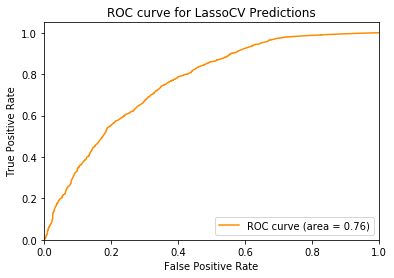

In [14]:
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for LassoCV Predictions')
plt.legend(loc="lower right")
plt.savefig('figures/lassoROC')
plt.show()

In [15]:
# Choosing the rounding threshold where the true positive rate
# is greater than 0.9
loc = np.min(np.where(tpr > 0.9))
fpr[loc]
threshold = thresh[loc]
# Rounding the predictions based on the threshold
rounded = []
for i in y_pred:
    if i > threshold:
        rounded.append(1)
    else:
        rounded.append(0)
rounded_y_pred = np.array(rounded)

In [16]:
confusion_matrix(y_test, rounded_y_pred)

array([[  777,   983],
       [ 1534, 13741]])

True Negatives: 777

False Negatives: 1534

True Positives: 13741

False Positives: 983

Calculating the raw binary accuracy rate

In [18]:
accuracy = (13741+777) / (13741 + 777 + 1534 + 983)

In [19]:
accuracy

0.852245377164661

In [20]:
coefficients = pd.DataFrame({'variable':X_train.columns, 'coef':predictor.coef_,})
# Factors that predict for failure
coefficients.sort_values(by='coef').head(20)

,coef,variable
149,-0.564423,weaptype1_txt_Radiological
28,-0.493795,targtype1_txt_Unknown
141,-0.332358,weaptype1_txt_Biological
164,-0.261598,weapsubtype1_txt_Letter Bomb
144,-0.238493,weaptype1_txt_Fake Weapons
59,-0.209693,targsubtype1_txt_Head of State
100,-0.189761,targsubtype1_txt_Personnel
177,-0.179400,weapsubtype1_txt_Time Fuse
142,-0.159859,weaptype1_txt_Chemical
1,-0.153337,attacktype1_txt_Assassination


In [21]:
# Factors that predict for success
coefficients.sort_values(by='coef', ascending=False).head(20)

,coef,variable
2,0.127350,attacktype1_txt_Bombing/Explosion
168,0.082603,weapsubtype1_txt_Poisoning
127,0.075595,targsubtype1_txt_Taxi/Rickshaw
170,0.075345,"weapsubtype1_txt_Projectile (rockets, mortars,..."
38,0.072495,targsubtype1_txt_Bus (excluding tourists)
147,0.060172,weaptype1_txt_Melee
64,0.058234,targsubtype1_txt_Intelligence
5,0.049466,attacktype1_txt_Hostage Taking (Barricade Inci...
153,0.049003,weapsubtype1_txt_Arson/Fire
48,0.046772,targsubtype1_txt_Electricity
